# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MinMaxScaler

# Data input and basic statistics

In [2]:
data = pd.read_csv("dataset.csv")


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   title              10000 non-null  object 
 2   genre              9997 non-null   object 
 3   original_language  10000 non-null  object 
 4   overview           9987 non-null   object 
 5   popularity         10000 non-null  float64
 6   release_date       10000 non-null  object 
 7   vote_average       10000 non-null  float64
 8   vote_count         10000 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 703.3+ KB
None


In [4]:
print(data.describe())

                  id    popularity  vote_average    vote_count
count   10000.000000  10000.000000  10000.000000  10000.000000
mean   161243.505000     34.697267      6.621150   1547.309400
std    211422.046043    211.684175      0.766231   2648.295789
min         5.000000      0.600000      4.600000    200.000000
25%     10127.750000      9.154750      6.100000    315.000000
50%     30002.500000     13.637500      6.600000    583.500000
75%    310133.500000     25.651250      7.200000   1460.000000
max    934761.000000  10436.917000      8.700000  31917.000000


# Exploratory Data Analysis

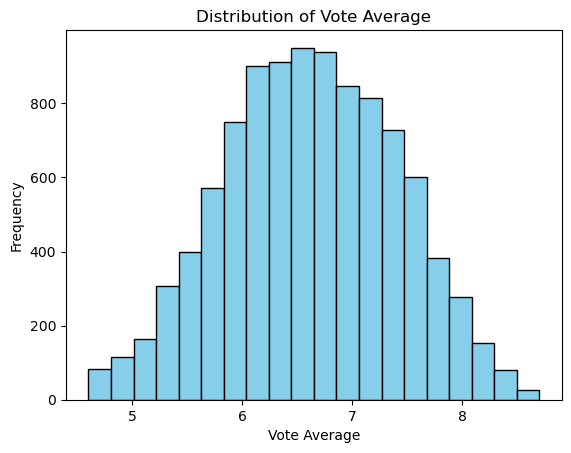

In [5]:
plt.hist(data['vote_average'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

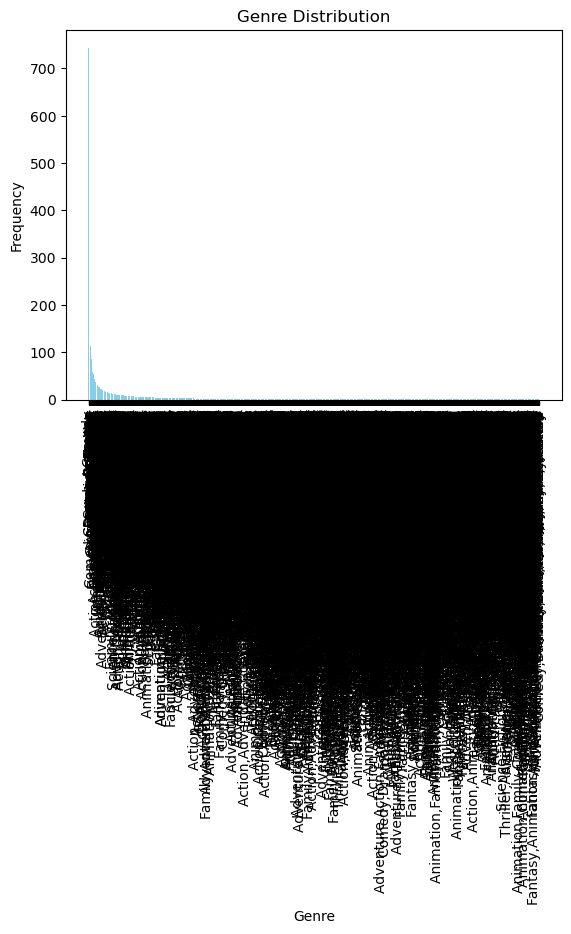

In [6]:
genre_counts = data['genre'].value_counts()
plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing

In [7]:
data.dropna(inplace=True)

In [8]:
data['release_date'] = pd.to_datetime(data['release_date'])

In [9]:
data = pd.get_dummies(data, columns=['original_language', 'genre'])

In [10]:
scaler = MinMaxScaler()
data[['popularity', 'vote_average', 'vote_count']] = scaler.fit_transform(data[['popularity', 'vote_average', 'vote_count']])

# Model Evaluation Function

In [11]:
def evaluate_model(predictions, actual):
    return mean_squared_error(predictions, actual)

# Model Training - Collaborative Filtering

In [12]:
reader = Reader(rating_scale=(0, 10))

In [13]:
data_surprise = Dataset.load_from_df(data[['id', 'title', 'vote_average']], reader)


In [14]:
algo_svd = SVD()

In [15]:
results_svd = cross_validate(algo_svd, data_surprise, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1873  0.1888  0.1857  0.1853  0.1861  0.1866  0.0013  
Fit time          0.30    0.28    0.28    0.32    0.29    0.29    0.01    
Test time         0.03    0.02    0.02    0.03    0.02    0.02    0.01    


# Model Training - Content-Based Filtering

In [16]:
tfidf = TfidfVectorizer(stop_words='english')
overview_matrix = tfidf.fit_transform(data['overview'].values.astype('U'))


In [17]:
cosine_sim = linear_kernel(overview_matrix, overview_matrix)

#  Model Selection


In [18]:
print("RMSE for Collaborative Filtering (SVD):", results_svd['test_rmse'].mean())


RMSE for Collaborative Filtering (SVD): 0.18663063581145783


In [19]:
def content_based_recommendations(title):
    idx = data[data['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return data['title'].iloc[movie_indices].tolist()

In [20]:
print("Content-Based Recommendations for 'The Dark Knight':", content_based_recommendations('The Dark Knight'))

Content-Based Recommendations for 'The Dark Knight': ['Batman: The Long Halloween, Part One', 'Batman: The Long Halloween, Part Two', 'The Dark Knight Rises', 'Batman', 'Batman: The Killing Joke', 'Batman: The Dark Knight Returns, Part 2', 'The Batman', 'Batman Forever', 'Batman: Under the Red Hood', 'Batman: Gotham by Gaslight']


# Visualize Results

In [21]:
recommendations = content_based_recommendations('The Dark Knight')
unique_recommendations = list(set(recommendations))

In [22]:
vote_averages = data[data['title'].isin(unique_recommendations)].groupby('title')['vote_average'].mean()

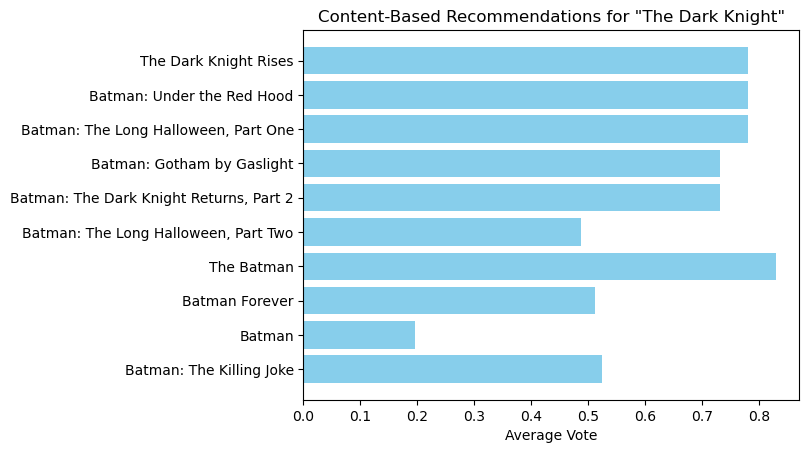

In [23]:
plt.barh(range(len(unique_recommendations)), vote_averages, color='skyblue')
plt.yticks(range(len(unique_recommendations)), unique_recommendations)
plt.xlabel('Average Vote')
plt.title('Content-Based Recommendations for "The Dark Knight"')
plt.show()

# Predictions

In [24]:
def predict_rating(user_id, movie_id):
    return algo_svd.predict(user_id, movie_id).est

In [25]:
user_id = 1
movie_id = 1234

In [26]:
print("Predicted rating for user {} on movie {}: {:.2f}".format(user_id, movie_id, predict_rating(user_id, movie_id)))

Predicted rating for user 1 on movie 1234: 0.49
